# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

---
# 1. Подготовка данных

### Импортируем необходимые библиотеки

In [861]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

### Считываем данные

In [862]:
churn_df = pd.read_csv('D:/3D Objects/Praktikum/Data/Churn.csv')
print(churn_df.info())
churn_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
Unnamed: 0         10000 non-null int64
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(9), object(3)
memory usage: 1.1+ MB
None


,Unnamed: 0,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Имеем таблицу с **10000** строками, есть около 1000 проусков в столбце **Tenure** (количество недвижимости).

### Описание данных
 - **RowNumber** — индекс строки в данных
 - **CustomerId** — уникальный идентификатор клиента
 - **Surname** — фамилия
 - **CreditScore** — кредитный рейтинг
 - **Geography** — страна проживания
 - **Gender** — пол
 - **Age** — возраст
 - **Tenure** — количество недвижимости у клиента
 - **Balance** — баланс на счёте
 - **NumOfProducts** — количество продуктов банка, используемых клиентом
 - **HasCrCard** — наличие кредитной карты
 - **IsActiveMember** — активность клиента
 - **EstimatedSalary** — предполагаемая зарплата
 - **Exited** — факт ухода клиента

Предстоит предсказывать значение столбца **Exited** по значениям в других столбцах.

### Предобработка данных

Необходимо заполнить пропуски в столбце **Tenure**.
Для выбора метода заполнения взглянем, какие значения встречаются в этом столбце:

In [863]:
churn_df.Tenure.value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Видим, что данные в столбце распределены равномерно в диапазоне от 0 до 10, выбросов нет.\
Уместным будет заполнение **медианой**, округленной до ближайшего целого числа (т.к. количество недвижимости может быть представлено только целыми числами).

In [864]:
churn_df['Tenure'] = churn_df.Tenure.fillna(round(churn_df.Tenure.median()))
churn_df.Tenure.value_counts()

5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: Tenure, dtype: int64

### Подготовка данных для обучения моделей
Для корректного обучения некоторых моделей необходимо заменить строковые данные на численные, т.е. провести кодирование.\
Это столбцы: **Surname, Geography, Gender**.

Также стоит исключить столбцы **RowNumber** и **Unnamed: 0** из таблицы, поскольку они не несут в себе никакой информации о клиентах, а лишь показывают номер строки.\
Аналогично, столбец **CustomerId**, указывает лишь номер id клиента в базе банка, никак не характеризуя его.\
Столбец **Surname** содержит фамилию, следовательно, не несет в себе информацию, полезную для выявления клиентов, планирующих уход из банка (в теории, может присутствовать некоторая зависимость между фамилией и шансом ухода из банка, однако модель, очевидно, не сможет распознать её).

In [865]:
churn_df = churn_df.drop(['RowNumber', 'Unnamed: 0', 'CustomerId', 'Surname'], axis=1)
churn_df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


#### Gender

Поскольку данные в этом столбце могут принимать всего два значения, применим **прямое кодирование** (**One-Hot Encoding**).\
Подойдет метод **get_dummies** библиотеки **pandas**, однако, чтобы не создавать новые столбцы, воспользуемся методом **replace()**.

In [866]:
print(churn_df.Gender.value_counts())
churn_df['Gender'] = churn_df.Gender.replace(['Male', 'Female'], [0, 1])
churn_df.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64


0    5457
1    4543
Name: Gender, dtype: int64

#### Geography

Для выбора подходящего метода кодирования узнаем, сколько различных значений могут принимать данные в этом столбце.

In [867]:
churn_df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Всего 3 различных значения. Оптимальным будет **прямое кодирование** (**One-Hot Encoding**).\
Воспользуемся методом **pd.get_dummies** с параметром **drop_first=True**, чтобы не создавать третий столбец, данные в котором напрямую зависят от двух других столбцов.

In [868]:
churn_df = pd.get_dummies(churn_df, columns=['Geography'], drop_first=True)
churn_df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,1,42,2.0,0.00,1,1,1,101348.88,1,0,0
1,608,1,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,502,1,42,8.0,159660.80,3,1,0,113931.57,1,0,0


### Масштабирование признаков

Поскольку в таблице присутствуют признаки с разными разбросами значений, модель может посчитать признаки с большими значениями и разбросами важнее. Чтобы избежать этого, проведем стандартизацию данных.

In [869]:
from sklearn.preprocessing import StandardScaler

# столбцы для масштабирования
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(churn_df[numeric])
churn_df_scaled = churn_df
churn_df_scaled[numeric] = scaler.transform(churn_df[numeric])
churn_df_scaled.head(5)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,-0.326221,1,0.293517,-1.086246,-1.225848,-0.911583,1,1,0.021886,1,0,0
1,-0.440036,1,0.198164,-1.448581,0.117350,-0.911583,0,1,0.216534,0,0,1
2,-1.536794,1,0.293517,1.087768,1.333053,2.527057,1,0,0.240687,1,0,0
3,0.501521,1,0.007457,-1.448581,-1.225848,0.807737,0,0,-0.108918,0,0,0
4,2.063884,1,0.388871,-1.086246,0.785728,-0.911583,1,1,-0.365276,0,0,1


### Разделение на выборки

Поскольку мы не имеем отдельных тестовых данных для проверки моделей, разделим данные в соотношении **3:1:1** \
**- Обучающая, Валидационная и Тестовая** выборки соответственно.

In [870]:
from sklearn.model_selection import train_test_split

df_train, df_test_and_valid = train_test_split(churn_df_scaled, test_size=0.4, random_state=42)
df_test, df_valid = train_test_split(df_test_and_valid, test_size=0.5, random_state=42)
print('train lenght:', len(df_train))
print('valid lenght:', len(df_valid))
print('test lenght:', len(df_test))

train lenght: 6000
valid lenght: 2000
test lenght: 2000


Теперь создадим функцию, которая разделит выборки на **признаки (features)** и **целевой признак (target)**.

In [871]:
def features_target_split(df, target):
    features = df.drop([target], axis=1)
    target = df[target]
    return features, target

train_features, train_target = features_target_split(df_train, 'Exited')
valid_features, valid_target = features_target_split(df_valid, 'Exited')
test_features, test_target = features_target_split(df_test, 'Exited')

Также подготовим объединенный датасет из обучающей и валидационной выборок, чтобы модели лучше обучились перед финальным тестированием.

In [872]:
final_features = train_features.append(valid_features)
final_target = train_target.append(valid_target)
print('features:', len(final_features), 'target:', len(final_target))

features: 8000 target: 8000


## Вывод

Загружена и изучена таблица с данными о поведении клиентов, устранены имевшиеся проблемы, а именно:
- Пропуски в столбце **Tenure** (Недвижимость) заменены **медианой**.
- Удалены столбцы, не требующиеся для обучения модели: **Unnamed: 0, RowNumber, CustomerId, Surname**.
- Проведено прямое кодирование столбцов **Gender** и **Geography**.
- Выполнено масштабирование признаков.
- Данные разделены на три выборки: **обучающую, валидационную и тестовую**.

Все готово для обучения моделей.

---
# 2. Исследование задачи

### Баланс классов

Изучим баланс классов в столбцах, в которых может наблюдаться дисбаланс, а именно:\
**Gender, HasCrCard, IsActiveMember, Exited, Geography_Germany, Geography_Spain**

In [873]:
churn_df_scaled.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Записей с целевым признаком **Exited = 0** всего **20%** от общего числа, имеем дело с дисбалансом классов.

### Обучение без учета дисбаланса

Имеем дело с задачей бинарной классификации, поэтому используем **Логистическую регрессию, Решающее дерево и Случайный лес**.\
Для оценки эффективности моделей используем **f1-меру**, поскольку при дисбалансе классов эта метрика предпочтительнее.

#### Логистическая регрессия

Обучим модель и сравним значение f1_score сразу на обучающей и валидационной выборках

In [874]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear')
model.fit(train_features, train_target)

print('Logistic Regression train f1_score', f1_score(train_target, model.predict(train_features)))
print('Logistic Regression valid f1_score', f1_score(valid_target, model.predict(valid_features)))

Logistic Regression train f1_score 0.3240963855421687
Logistic Regression valid f1_score 0.31918505942275044


Получаем плохой результат на обеих выборках, значит проблема не в переобучении/недообучении модели.\
Очевидно, сильно улучшить модель изменяя гиперпараметры не получится, требуется дополнительная работа со входными данными.

#### Решающее дерево и Случайный лес

Аналогично, обучим модели решающего дерева и случайного леса, задав для обоих алгоритмов **max_depth**, чтобы избежать переобучения.\
Проводить оценку будем также при помощи **f1_score**.

In [875]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
model_forest = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=1000)

model_tree.fit(train_features, train_target)
model_forest.fit(train_features, train_target)

print('Tree train f1_score', f1_score(model_tree.predict(train_features), train_target))
print('Forest train f1_score', f1_score(model_forest.predict(train_features), train_target))
print()
print('Tree valid f1_score', f1_score(model_tree.predict(valid_features), valid_target))
print('Forest valid f1_score', f1_score(model_forest.predict(valid_features), valid_target))

Tree train f1_score 0.5784215784215785
Forest train f1_score 0.723963599595551

Tree valid f1_score 0.5824964131994261
Forest valid f1_score 0.5988200589970502


Получаем **f1_score = 0.58** для дерева, что несколько ниже необходимого, и 
**0.599** для леса, то есть достаточное значение.

При этом для леса есть небольшое переобучение на обучающей выборке из-за параметра **max_depth = 10**, однако при снижении максимальной глубины, падает качество и на валидационной выборке.

#### Выводы

- Даже не учитывая дисбаланс классов, модель **случайного леса** показала удовлетворительные (**f1_score = 0.599**) результаты на валидационной выборке.
- Модель **решающего дерева** показала себя также неплохо (**f1_score = 0.58**), однако значение **f1-меры** меньше необходимого.
- **Логистическая регрессия** показала неудовлетворительные (**f1_score = 0.32**) результаты, т.е. модель чувствительна к дисбалансу классов.

---
# 3. Борьба с дисбалансом

Для борьбы с дисбалансом используем несколько подходов:

- Изменение порога
- Взвешивание классов
- Увеличение выборки (Upsampling)
- Уменьшение выборки (Downsampling)

#### Для удобства создадим несколько функций, которые облегчат создание, настройку и тестирование различных моделей.

При этом изменение порога и взвешивание классов проведем внутри этих функций.\
Таким образом мы сможем легко комбинировать разные подходы, изменяя при этом только обучающие выборки.

---
### Логистическая регрессия

Функция **optimize_log_regression** будет брать на вход две выборки - обучающую и валидационную, с соответствующими целевыми значениями.\
Затем:
- Создавать и обучать модель логистической регрессии
- Выводить **f1_score** при взвешивании классов и без него
- Для лучшего варианта подбирать оптимальный порог
- Выводить наибольшее значение **f1_score** и **ROC-AUC** 
- Возвращать оптимальные значения веса и порога

In [876]:
def optimize_log_regression(train_features, train_target, valid_features, valid_target):
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import f1_score, roc_auc_score
    
    f1_best = 0
    threshold_best = 0
    class_weight_best = None
    
    for class_weight in [None, 'balanced']:
        
        model = LogisticRegression(solver='liblinear', class_weight=class_weight)
        model.fit(train_features, train_target)
        predictions = model.predict(valid_features)
        f1 = f1_score(valid_target, predictions)
        
        if f1 >= f1_best:
            f1_best = f1
            class_weight_best = class_weight
    
    print('Оптимальный вес: {} | f1_score: {:.3f}'.format(class_weight_best, f1_best))
    print()
    
    model = LogisticRegression(solver='liblinear', class_weight=class_weight_best)
    model.fit(train_features, train_target)
    
    valid_probabilities = model.predict_proba(valid_features)
    valid_probabilities_one = valid_probabilities[:, 1]
    
    roc_auc = roc_auc_score(valid_target, valid_probabilities_one)
    
    # choose best threshold
    for threshold in np.arange(0.1, 0.8, 0.025):
          
        valid_predicted = valid_probabilities_one > threshold
        
        f1 = f1_score(valid_target, valid_predicted)
        
        if (f1 > f1_best):
            f1_best = f1
            threshold_best = threshold
        
        print('Порог = {:.2f} | F1-Мера = {:.3f}'.format(
        threshold, f1))

    print()
    # results
    
    # roc_auc_score
    model = LogisticRegression(solver='liblinear', class_weight=class_weight_best)
    model.fit(train_features, train_target)
    valid_probabilities = model.predict_proba(valid_features)
    valid_probabilities_one = valid_probabilities[:, 1]
    
    print('Оптимальный вес: {} | Оптимальный порог: {:.2f} | ROC-AUC: {:.3f} | Наибольшее значение F1-меры: {:.3f} '.format(
        class_weight_best, threshold_best, roc_auc, f1_best))

---
### Решающее дерево

Функция **optimize_decision_tree** будет брать на вход две выборки - обучающую и валидационную, с соответствующими целевыми значениями.\
Затем:
- Создавать и обучать модель решающего дерева
- Выводить **f1_score** при различных значениях максимальной глубины
- Выводить наибольшее значение **f1_score** и **ROC-AUC** 
- Возвращать оптимальную максимальную глубину дерева.

In [877]:
def optimize_decision_tree(train_features, train_target, valid_features, valid_target):
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.metrics import f1_score, roc_auc_score
    
    f1_best = 0
    max_depth_best = 0
    class_weight_best = None
    
    # class_weight
    for class_weight in [None, 'balanced']:
        
        model = DecisionTreeClassifier(random_state=42, class_weight=class_weight)
        model.fit(train_features, train_target)
        predictions = model.predict(valid_features)
        f1 = f1_score(valid_target, predictions)
        
        if f1 >= f1_best:
            f1_best = f1
            class_weight_best = class_weight
    
    print('Оптимальный вес: {} | f1_score: {:.3f}'.format(class_weight_best, f1_best))
    print()
    
    # data for ploting
    f1_train_data=[]
    f1_valid_data=[]
    
    for max_depth in np.arange(2, 13, 1):
        
        model = DecisionTreeClassifier(random_state=42, max_depth=max_depth, class_weight=class_weight_best)
        model.fit(train_features, train_target)
        
        train_predictions = model.predict(train_features)
        valid_predictions = model.predict(valid_features)
        
        f1_train = f1_score(train_target, train_predictions)
        f1_valid = f1_score(valid_target, valid_predictions)
        
        f1_train_data.append(f1_train)
        f1_valid_data.append(f1_valid)
        
        if f1_valid > f1_best:
            f1_best = f1_valid
            max_depth_best = max_depth
        
    plt.figure()
    plt.grid(True)
    plt.plot(np.arange(2, 13, 1), f1_train_data, label='train')
    plt.plot(np.arange(2, 13, 1), f1_valid_data, label='valid')
    plt.xlabel('max_depth')
    plt.ylabel('f1_score')
    plt.legend()
    plt.show()
    
    # roc-auc
    model = DecisionTreeClassifier(random_state=42, max_depth=max_depth_best, class_weight=class_weight_best)
    model.fit(train_features, train_target)
    valid_probabilities = model.predict_proba(valid_features)
    valid_probabilities_one = valid_probabilities[:, 1]
    
    roc_auc = roc_auc_score(valid_target, valid_probabilities_one)
    
    print('Оптимальный вес: {} | Оптимальная глубина: {} | ROC-AUC: {:.3f} | Наибольшее значение F1-Меры: {:.3f}'.format(
    class_weight_best, max_depth_best, roc_auc, f1_best,))

---
### Случайный лес

Функция **optimize_random_forest** будет брать на вход две выборки - обучающую и валидационную, с соответствующими целевыми значениями.\
Затем:
- Создавать и обучать модель случайного леса
- Выводить **f1_score** при различных значениях максимальной глубины и числа деревьев
- Выводить наибольшее значение **f1_score** и **ROC-AUC** 
- Возвращать оптимальную максимальную глубину одного дерева и оптимальное число деревьев

In [878]:
def optimize_random_forest(train_features, train_target, valid_features, valid_target):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import f1_score, roc_auc_score
    
    f1_best = 0
    max_depth_best = 2
    n_estimators_best = 25
    class_weight_best = None
    
    # class_weight
    for class_weight in [None, 'balanced']:
        
        model = RandomForestClassifier(random_state=42, max_depth=max_depth_best, n_estimators=25, class_weight=class_weight)
        model.fit(train_features, train_target)
        predictions = model.predict(valid_features)
        f1 = f1_score(valid_target, predictions)
        
        if f1 >= f1_best:
            f1_best = f1
            class_weight_best = class_weight
    
    print('Оптимальный вес: {} | f1_score: {:.3f}'.format(class_weight_best, f1_best))
    print()
    
    # data for ploting
    f1_train_data=[]
    f1_valid_data=[]
    
    # max_depth
    for max_depth in np.arange(2, 13, 1):
        
        model = RandomForestClassifier(
            random_state=42, max_depth=max_depth, n_estimators=25, class_weight=class_weight_best)
        model.fit(train_features, train_target)
        
        train_predictions = model.predict(train_features)
        valid_predictions = model.predict(valid_features)
        
        f1_train = f1_score(train_target, train_predictions)
        f1_valid = f1_score(valid_target, valid_predictions)
        
        f1_train_data.append(f1_train)
        f1_valid_data.append(f1_valid)
        
        if f1_valid >= f1_best:
            f1_best = f1_valid
            max_depth_best = max_depth
        
    plt.figure()
    plt.grid(True)
    plt.plot(np.arange(2, 13, 1), f1_train_data, label='train')
    plt.plot(np.arange(2, 13, 1), f1_valid_data, label='valid')
    plt.xlabel('max_depth')
    plt.ylabel('f1_score')
    plt.legend()
    plt.show()
    
    # n_estimators
    
    f1_train_data=[]
    f1_valid_data=[]
    
    for n_estimators in np.arange(25, 400, 25):
        
        model = RandomForestClassifier(
            random_state=42, max_depth=max_depth_best, n_estimators=n_estimators, class_weight=class_weight_best)
        model.fit(train_features, train_target)
        
        train_predictions = model.predict(train_features)
        valid_predictions = model.predict(valid_features)
        
        f1_train = f1_score(train_target, train_predictions)
        f1_valid = f1_score(valid_target, valid_predictions)
        
        f1_train_data.append(f1_train)
        f1_valid_data.append(f1_valid)
        
        if f1_valid > f1_best:
            f1_best = f1_valid
            n_estimators_best = n_estimators
        
    plt.figure()
    plt.grid(True)
    plt.plot(np.arange(25, 400, 25), f1_train_data, label='train')
    plt.plot(np.arange(25, 400, 25), f1_valid_data, label='valid')
    plt.xlabel('n_estimators')
    plt.ylabel('f1_score')
    plt.legend()
    plt.show()
    
    # roc-auc
    model = RandomForestClassifier(
        random_state=42, max_depth=max_depth_best, n_estimators=n_estimators_best, class_weight=class_weight_best)
    model.fit(train_features, train_target)
    valid_probabilities = model.predict_proba(valid_features)
    valid_probabilities_one = valid_probabilities[:, 1]
    
    roc_auc = roc_auc_score(valid_target, valid_probabilities_one)
    
    print('Оптимальный вес: {} | Оптимальная глубина: {} | Оптимальное число деревьев: {} | ROC-AUC: {:.3f} | Наибольшее значние F1-Меры: {:.3f}'.format(
    class_weight_best, max_depth_best, n_estimators_best, roc_auc, f1_best))

---

Протестируем методы борьбы с дисбалансом, заложенные в самих функциях, не изменяя при этом обучающую выборку:

#### Линейная регрессия

In [879]:
optimize_log_regression(train_features, train_target, valid_features, valid_target)

Оптимальный вес: balanced | f1_score: 0.502

Порог = 0.10 | F1-Мера = 0.359
Порог = 0.12 | F1-Мера = 0.367
Порог = 0.15 | F1-Мера = 0.373
Порог = 0.17 | F1-Мера = 0.382
Порог = 0.20 | F1-Мера = 0.390
Порог = 0.22 | F1-Мера = 0.402
Порог = 0.25 | F1-Мера = 0.418
Порог = 0.27 | F1-Мера = 0.430
Порог = 0.30 | F1-Мера = 0.440
Порог = 0.32 | F1-Мера = 0.448
Порог = 0.35 | F1-Мера = 0.454
Порог = 0.37 | F1-Мера = 0.464
Порог = 0.40 | F1-Мера = 0.473
Порог = 0.42 | F1-Мера = 0.488
Порог = 0.45 | F1-Мера = 0.503
Порог = 0.47 | F1-Мера = 0.506
Порог = 0.50 | F1-Мера = 0.502
Порог = 0.52 | F1-Мера = 0.526
Порог = 0.55 | F1-Мера = 0.527
Порог = 0.57 | F1-Мера = 0.513
Порог = 0.60 | F1-Мера = 0.513
Порог = 0.62 | F1-Мера = 0.517
Порог = 0.65 | F1-Мера = 0.508
Порог = 0.67 | F1-Мера = 0.489
Порог = 0.70 | F1-Мера = 0.473
Порог = 0.72 | F1-Мера = 0.449
Порог = 0.75 | F1-Мера = 0.399
Порог = 0.77 | F1-Мера = 0.344

Оптимальный вес: balanced | Оптимальный порог: 0.55 | ROC-AUC: 0.784 | Наибольшее знач

#### Решающее дерево

Оптимальный вес: None | f1_score: 0.513



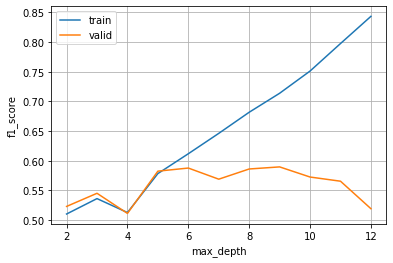

Оптимальный вес: None | Оптимальная глубина: 9 | ROC-AUC: 0.798 | Наибольшее значение F1-Меры: 0.590


In [880]:
optimize_decision_tree(train_features, train_target, valid_features, valid_target)

#### Случайный лес

Оптимальный вес: balanced | f1_score: 0.578



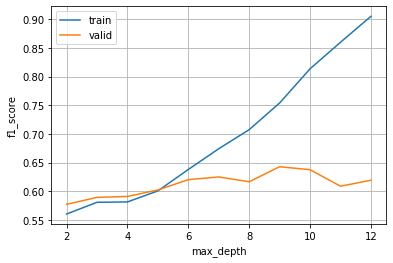

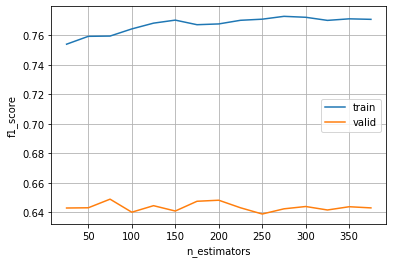

Оптимальный вес: balanced | Оптимальная глубина: 9 | Оптимальное число деревьев: 75 | ROC-AUC: 0.863 | Наибольшее значние F1-Меры: 0.649


In [881]:
optimize_random_forest(train_features, train_target, valid_features, valid_target)

### Вывод

Даже изменения обучающих выборок получаем серьезное увеличение качества моделей (по f1-мере) на валидационной выборке:
- Линейная регрессия: **f1_score = 0.527, ROC-AUC = 0.784** (значительный прирост)
- Решающее дерево: **f1_score = 0.590, ROC-AUC = 0.798** (незначительный прирост)
- Случайный лес: **f1_score = 0.649, ROC-AUC = 0.863** (значительный прирост)

---
### Увеличение выборки (Upsampling)

**Суть метода заключается в следующем:**
- Обучающая выборка разделяется на отрицательные и положительные объекты
- Положительные объекты несколько раз дублируются
- Создается новая обучающая выборка с увеличенным числом положительных объектов
- Вновь созданная обучающая выборка перемешивается

**Для удобства создадим функцию:**

In [882]:
def upsample(features, target, repeat):
    
    from sklearn.utils import shuffle
    
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones]*repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [883]:
features_upsampled, target_upsampled = upsample(train_features, train_target, 4)
print('Число объектов с целевым признаком = 1 к общему числу объектов')
len(target_upsampled[target_upsampled==1]) / len(target_upsampled)

Число объектов с целевым признаком = 1 к общему числу объектов


0.5069724202045244

#### Проверим как увеличение выборки повлияет на качество моделей:

#### Линейная регрессия

In [884]:
optimize_log_regression(features_upsampled, target_upsampled, valid_features, valid_target)

Оптимальный вес: None | f1_score: 0.502

Порог = 0.10 | F1-Мера = 0.358
Порог = 0.12 | F1-Мера = 0.365
Порог = 0.15 | F1-Мера = 0.373
Порог = 0.17 | F1-Мера = 0.380
Порог = 0.20 | F1-Мера = 0.388
Порог = 0.22 | F1-Мера = 0.400
Порог = 0.25 | F1-Мера = 0.415
Порог = 0.27 | F1-Мера = 0.426
Порог = 0.30 | F1-Мера = 0.437
Порог = 0.32 | F1-Мера = 0.446
Порог = 0.35 | F1-Мера = 0.452
Порог = 0.37 | F1-Мера = 0.460
Порог = 0.40 | F1-Мера = 0.471
Порог = 0.42 | F1-Мера = 0.487
Порог = 0.45 | F1-Мера = 0.503
Порог = 0.47 | F1-Мера = 0.507
Порог = 0.50 | F1-Мера = 0.502
Порог = 0.52 | F1-Мера = 0.516
Порог = 0.55 | F1-Мера = 0.528
Порог = 0.57 | F1-Мера = 0.517
Порог = 0.60 | F1-Мера = 0.516
Порог = 0.62 | F1-Мера = 0.515
Порог = 0.65 | F1-Мера = 0.508
Порог = 0.67 | F1-Мера = 0.491
Порог = 0.70 | F1-Мера = 0.479
Порог = 0.72 | F1-Мера = 0.469
Порог = 0.75 | F1-Мера = 0.406
Порог = 0.77 | F1-Мера = 0.352

Оптимальный вес: None | Оптимальный порог: 0.55 | ROC-AUC: 0.784 | Наибольшее значение F1-

#### Решающее дерево

Оптимальный вес: None | f1_score: 0.507



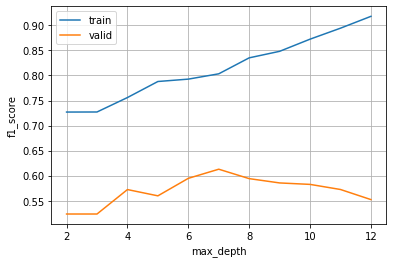

Оптимальный вес: None | Оптимальная глубина: 7 | ROC-AUC: 0.818 | Наибольшее значение F1-Меры: 0.613


In [885]:
optimize_decision_tree(features_upsampled, target_upsampled, valid_features, valid_target)

#### Случайный лес

Оптимальный вес: balanced | f1_score: 0.571



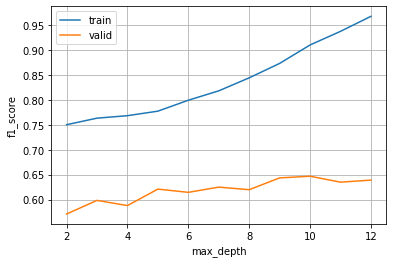

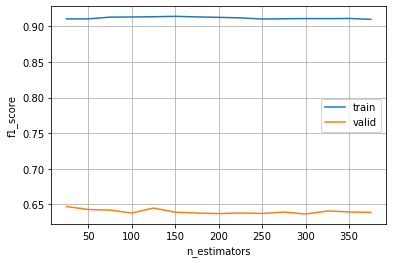

Оптимальный вес: balanced | Оптимальная глубина: 10 | Оптимальное число деревьев: 25 | ROC-AUC: 0.864 | Наибольшее значние F1-Меры: 0.647


In [886]:
optimize_random_forest(features_upsampled, target_upsampled, valid_features, valid_target)

### Вывод

При увеличении выборки качество возрасло только на Решающем дереве. Другие модели без изменений:
- Линейная регрессия: **f1_score = 0.528, ROC-AUC = 0.784** (без изменений)
- Решающее дерево: **f1_score = 0.613, ROC-AUC = 0.818** (средний прирост)
- Случайный лес: **f1_score = 0.647, ROC-AUC = 0.864** (без изменений)

---
### Уменьшение выборки (Downsampling)

**Суть метода заключается в следующем:**
- Обучающая выборка разделяется на отрицательные и положительные объекты
- Отбрасывается часть отрицательных объектов
- Создается новая обучающая выборка с уменьшенным числом отрицательных объектов
- Вновь созданная обучающая выборка перемешивается

**Для удобства создадим функцию:**

In [887]:
def downsample(features, target, fraction):
    
    from sklearn.utils import shuffle
    
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [888]:
features_downsampled, target_downsampled = downsample(train_features, train_target, 0.4)
print('Число объектов с целевым признаком = 1 к общему числу объектов')
len(target_downsampled[target_downsampled==1]) / len(target_downsampled)

Число объектов с целевым признаком = 1 к общему числу объектов


0.39126275510204084

#### Проверим как уменьшение выборки повлияет на качество моделей:

#### Линейная регрессия

In [889]:
optimize_log_regression(features_downsampled, target_downsampled, valid_features, valid_target)

Оптимальный вес: None | f1_score: 0.514

Порог = 0.10 | F1-Мера = 0.373
Порог = 0.12 | F1-Мера = 0.385
Порог = 0.15 | F1-Мера = 0.402
Порог = 0.17 | F1-Мера = 0.418
Порог = 0.20 | F1-Мера = 0.429
Порог = 0.22 | F1-Мера = 0.442
Порог = 0.25 | F1-Мера = 0.450
Порог = 0.27 | F1-Мера = 0.459
Порог = 0.30 | F1-Мера = 0.471
Порог = 0.32 | F1-Мера = 0.484
Порог = 0.35 | F1-Мера = 0.501
Порог = 0.37 | F1-Мера = 0.503
Порог = 0.40 | F1-Мера = 0.502
Порог = 0.42 | F1-Мера = 0.523
Порог = 0.45 | F1-Мера = 0.524
Порог = 0.47 | F1-Мера = 0.514
Порог = 0.50 | F1-Мера = 0.514
Порог = 0.52 | F1-Мера = 0.511
Порог = 0.55 | F1-Мера = 0.506
Порог = 0.57 | F1-Мера = 0.491
Порог = 0.60 | F1-Мера = 0.480
Порог = 0.62 | F1-Мера = 0.470
Порог = 0.65 | F1-Мера = 0.423
Порог = 0.67 | F1-Мера = 0.385
Порог = 0.70 | F1-Мера = 0.358
Порог = 0.72 | F1-Мера = 0.317
Порог = 0.75 | F1-Мера = 0.304
Порог = 0.77 | F1-Мера = 0.271

Оптимальный вес: None | Оптимальный порог: 0.45 | ROC-AUC: 0.782 | Наибольшее значение F1-

#### Решающее дерево

Оптимальный вес: None | f1_score: 0.527



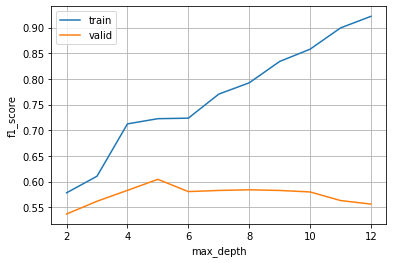

Оптимальный вес: None | Оптимальная глубина: 5 | ROC-AUC: 0.838 | Наибольшее значение F1-Меры: 0.604


In [890]:
optimize_decision_tree(features_downsampled, target_downsampled, valid_features, valid_target)

#### Случайный лес

Оптимальный вес: balanced | f1_score: 0.590



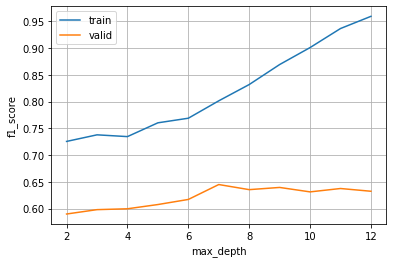

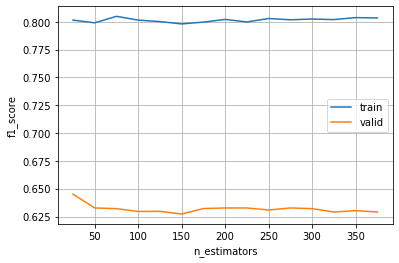

Оптимальный вес: balanced | Оптимальная глубина: 7 | Оптимальное число деревьев: 25 | ROC-AUC: 0.867 | Наибольшее значние F1-Меры: 0.645


In [891]:
optimize_random_forest(features_downsampled, target_downsampled, valid_features, valid_target)

### Вывод

При уменьшении выборки получаем результаты, аналогичные тем, что получены при увеличении выборки:
- Линейная регрессия: **f1_score = 0.524, ROC-AUC = 0.782** (без изменений)
- Решающее дерево: **f1_score = 0.604, ROC-AUC = 0.838** (незначительный прирост)
- Случайный лес: **f1_score = 0.645, ROC-AUC = 0.867**  (без изменений)
---

## Итог
   
Выходит, среди всех методов борьбы с дисбалансом классов, **наибольшее** влияние оказывает **взвешивание классов и изменение порога**.\
**Изменение выборки** (**upsampling** и **downsampling**) оказывает **меньшее** воздействие, однако эти результаты могут отличаться для других наборов данных.

---
# 4. Тестирование модели

Для обучения модели перед финальным тестированием используем подготовленную ранее выборку **final_features**, включающую обучающую и валидационную выборки.

Также предварительно проведем **upsampling**, т.к. этот метод борьбы с дисбалансом оказался наиболее эффективным.

In [892]:
final_features_upsampled, final_target_upsampled = upsample(final_features, final_target, 5)

print('Число объектов с целевым признаком = 1 к общему числу объектов')
len(final_target_upsampled[final_target_upsampled==1]) / len(final_target_upsampled)

Число объектов с целевым признаком = 1 к общему числу объектов


0.5663795460760186

### Линейная регрессия

In [893]:
optimize_log_regression(final_features_upsampled, final_target_upsampled, test_features, test_target)
print()

Оптимальный вес: balanced | f1_score: 0.465

Порог = 0.10 | F1-Мера = 0.327
Порог = 0.12 | F1-Мера = 0.331
Порог = 0.15 | F1-Мера = 0.340
Порог = 0.17 | F1-Мера = 0.348
Порог = 0.20 | F1-Мера = 0.352
Порог = 0.22 | F1-Мера = 0.364
Порог = 0.25 | F1-Мера = 0.373
Порог = 0.27 | F1-Мера = 0.384
Порог = 0.30 | F1-Мера = 0.392
Порог = 0.32 | F1-Мера = 0.402
Порог = 0.35 | F1-Мера = 0.418
Порог = 0.37 | F1-Мера = 0.421
Порог = 0.40 | F1-Мера = 0.435
Порог = 0.42 | F1-Мера = 0.443
Порог = 0.45 | F1-Мера = 0.450
Порог = 0.47 | F1-Мера = 0.458
Порог = 0.50 | F1-Мера = 0.465
Порог = 0.52 | F1-Мера = 0.459
Порог = 0.55 | F1-Мера = 0.469
Порог = 0.57 | F1-Мера = 0.465
Порог = 0.60 | F1-Мера = 0.463
Порог = 0.62 | F1-Мера = 0.458
Порог = 0.65 | F1-Мера = 0.455
Порог = 0.67 | F1-Мера = 0.426
Порог = 0.70 | F1-Мера = 0.415
Порог = 0.72 | F1-Мера = 0.381
Порог = 0.75 | F1-Мера = 0.362
Порог = 0.77 | F1-Мера = 0.343

Оптимальный вес: balanced | Оптимальный порог: 0.55 | ROC-AUC: 0.754 | Наибольшее знач

### Решающее дерево

Оптимальный вес: balanced | f1_score: 0.471



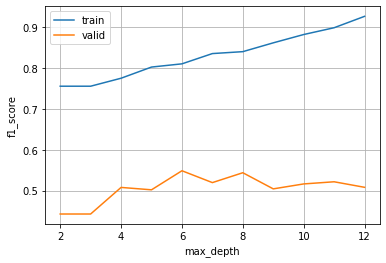

Оптимальный вес: balanced | Оптимальная глубина: 6 | ROC-AUC: 0.817 | Наибольшее значение F1-Меры: 0.549



In [894]:
optimize_decision_tree(final_features_upsampled, final_target_upsampled, test_features, test_target)
print()

### Случайный лес

Оптимальный вес: balanced | f1_score: 0.522



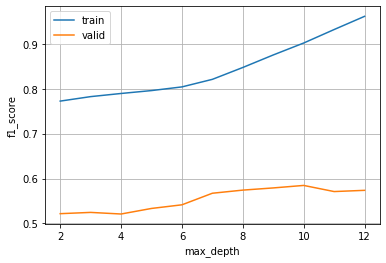

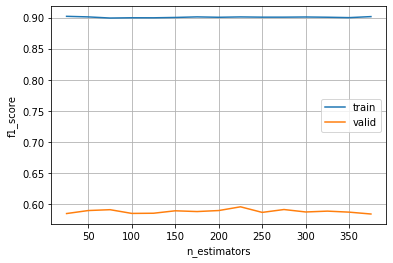

Оптимальный вес: balanced | Оптимальная глубина: 10 | Оптимальное число деревьев: 225 | ROC-AUC: 0.848 | Наибольшее значние F1-Меры: 0.596



In [895]:
optimize_random_forest(final_features_upsampled, final_target_upsampled, test_features, test_target)
print()

## Вывод

Несмотря на довольно высокие результаты на валидационной выборке, только модель **Случайного леса** показала удовлетворительный результат: значение **F1-Меры = 0.596**, а **ROC-AUC = 0.848**.

---

# Общий вывод:

**Целью** этого проекта было создание модели, прогнозирующей уход клиентов из банка.

Работа состоит из следующих этапов:
- Подготовка данных
- Исследование задачи
- Борьба с дисбалансом
- Тестирование модели

**На первом этапе** была загружена и изучена таблица с данными, устранены имевшиеся проблемы, а именно:
- Пропуски в столбце **Tenure** (Недвижимость) заменены **медианой**.
- Удалены столбцы, не требующиеся для обучения модели: **Unnamed: 0, RowNumber, CustomerId, Surname**.
- Проведено прямое кодирование столбцов **Gender** и **Geography**.
- Выполнено масштабирование признаков.
- Данные разделены на три выборки: **обучающую, валидационную и тестовую**.

**На втором этапе** был изучен баланс классов, а также проведено первичное обучение моделей без учета дисбаланса классов. По итогу можно сделать следующие выводы:
- **Линейная регрессия** очень чувствительна к дисбалансу классов
- **Решающее дерево** и **Случайный лес** показывают неплохие результаты даже при наличии дисбаланса классов.

**На третьем этапе** проведена работа по устранению дисбаланса классов. Использованы четыре метода:
- Изменение порога
- Взвешивание классов
- Увеличение выборки (Upsampling)
- Уменьшение выборки (Downsampling)

При этом изменение порога и взвешивание классов использованы как по отдельности, так и в сочетании изменением выборки.\
В последнем случае модель показала наилучшие результаты.

При этом, не смотря на то, что метрики **f1-мера** и **AUC-ROC** сильно коррелировали между собой, в некоторых случаях наблюдалось увеличение одной метрики без изменения/с небольшим ухудшением другой.

**На четвертом этапе** проведено финальное тестирование моделей, в результате которого модели на **тестовой** выборке показали результаты значительно **хуже** аналогичных на **валидационной** выборке, несмотря на неплохие показатели **AUC-ROC**.
- Логистическая регрессия не набрала необходимого значения **f1-меры** (**0.469** против **0.59** требуемых)
- Решающее дерево также получило неудовлетворительное значение **f1-меры** (**0.549** при **AUC-ROC = 0.817**)
- Модель Случайного леса выполнила задачу со значением **f1-меры = 0.596** и **AUC-ROC = 0.848**

# Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*